<a href="https://colab.research.google.com/github/celso-vitor/StomataCount/blob/main/StomataCount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Passo 1: Instalação de bibliotecas necessárias
!pip install opencv-python numpy matplotlib scikit-image tensorflow

# Passo 2: Importação das bibliotecas
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from google.colab import files

# Passo 3: Fazer upload de uma ou mais imagens
print("Faça upload de uma ou mais imagens:")
uploaded = files.upload()


Faça upload de uma ou mais imagens:


Saving 2.bmp to 2 (1).bmp
Saving 3.bmp to 3.bmp



Processando imagem: 2 (1).bmp


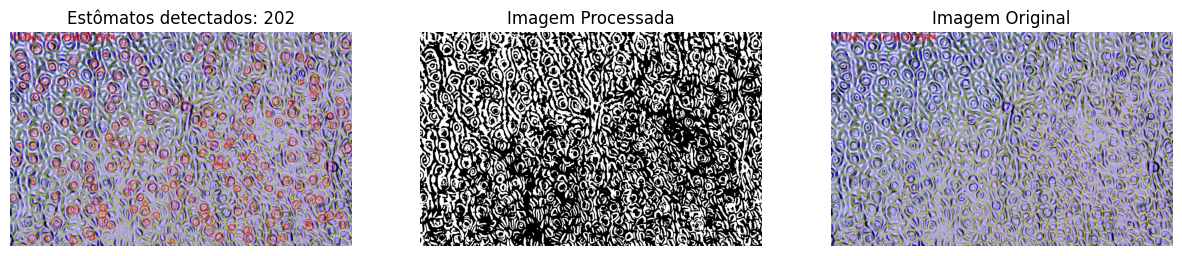


Processando imagem: 3.bmp


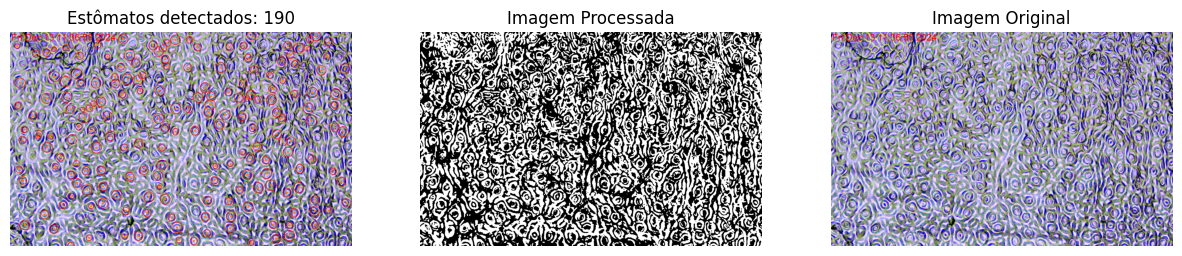


Resumo Final:
Imagem: 2 (1).bmp | Estômatos detectados: 202
Imagem: 3.bmp | Estômatos detectados: 190


In [ ]:
# Lista para armazenar os resultados de cada imagem
results = []

# Iterar sobre todas as imagens carregadas
for image_name, image_data in uploaded.items():
    print(f"\nProcessando imagem: {image_name}")

    # Passo 4: Aplicar escala de cinza
    img_gray = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

    # Passo 5: Pré-processamento adicional (refinado)
    def preprocess_image(img_gray):
        # Melhorar contraste (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_gray)

        # Redução de ruído (filtro mediana)
        img_blur = cv2.medianBlur(img_clahe, 3)  # Kernel menor (3x3)

        # Binarização (Otsu's threshold)
        _, img_bin = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Operação morfológica (fechamento para conectar áreas brancas)
        kernel = np.ones((3, 3), np.uint8)  # Kernel menor (3x3)
        img_dilated = cv2.dilate(img_bin, kernel, iterations=1)
        img_eroded = cv2.erode(img_dilated, kernel, iterations=1)

        # Operação morfológica adicional (abertura para remover ruídos pequenos)
        img_final = cv2.morphologyEx(img_eroded, cv2.MORPH_OPEN, kernel, iterations=1)

        return img_final

    # Aplicar pré-processamento adicional
    img_processed = preprocess_image(img_gray)

    # Passo 6: Detectar círculos usando Hough Circles (ajustado)
    def detect_circles(img_processed):
        # Garantir que a imagem esteja no formato correto (8 bits, escala de cinza)
        img_processed = np.uint8(img_processed)  # Converter para uint8 (8 bits)

        # Aplicar o algoritmo Hough Circles
        circles = cv2.HoughCircles(
            img_processed,
            method=cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=10,  # Valor moderado para evitar sobreposições
            param1=100,  # Sensibilidade moderada
            param2=28,   # Sensibilidade moderada
            minRadius=5,
            maxRadius=30
        )

        # Retornar os círculos detectados
        if circles is not None:
            return np.round(circles[0, :]).astype("int")
        else:
            return []

    # Detectar círculos
    circles = detect_circles(img_processed)

    # Remover sobreposições
    def filter_overlapping_circles(circles):
        if len(circles) == 0:
            return circles

        filtered_circles = []
        used_indices = set()

        for i in range(len(circles)):
            if i in used_indices:
                continue

            x1, y1, r1 = circles[i]
            keep_circle = True

            for j in range(i + 1, len(circles)):
                if j in used_indices:
                    continue

                x2, y2, r2 = circles[j]
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

                # Se os círculos se sobrepõem significativamente, descarte o menor
                if distance < (r1 + r2) * 0.6:  # Fator de tolerância ajustado
                    if r1 > r2:  # Mantenha o círculo com maior raio
                        used_indices.add(j)
                    else:
                        used_indices.add(i)
                        keep_circle = False
                        break

            if keep_circle:
                filtered_circles.append(circles[i])

        return np.array(filtered_circles)

    circles = filter_overlapping_circles(circles)

    # Passo 7: Desenhar os círculos na imagem original
    def draw_circles(image_path, circles):
        # Carregar a imagem colorida
        img_color = cv2.imread(image_path)

        # Desenhar os círculos detectados
        for (x, y, r) in circles:
            cv2.circle(img_color, (x, y), r, (0, 0, 255), 2)  # Desenha o círculo
            cv2.rectangle(img_color, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)  # Marca o centro

        return img_color

    # Desenhar os círculos
    img_with_circles = draw_circles(image_name, circles)

    # Passo 8: Exibir resultados
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img_with_circles, cv2.COLOR_BGR2RGB))
    plt.title(f"Estômatos detectados: {len(circles)}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_processed, cmap='gray')
    plt.title("Imagem Processada")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB))
    plt.title("Imagem Original")
    plt.axis('off')

    plt.show()

    # Armazenar o resultado para esta imagem
    results.append({
        "image_name": image_name,
        "stomata_count": len(circles)
    })

# Exibir resumo final
print("\nResumo Final:")
for result in results:
    print(f"Imagem: {result['image_name']} | Estômatos detectados: {result['stomata_count']}")